In [568]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import precision_score, recall_score
import matplotlib
import matplotlib.pyplot as plt

In [543]:
df = pd.read_csv("Dataset.csv")
df = pd.DataFrame(df)

df.head()

,No.,Time,Time since previous frame,Source,Destination,Time to Live,Data Length,Frame Length,Protocol
0,1,0.000000,0.000000,192.168.1.226,188.153.150.68,64,130.0,172,UDP
1,2,0.008723,0.008723,188.153.150.68,192.168.1.226,52,843.0,885,UDP
2,3,0.008725,0.000002,188.153.150.68,192.168.1.226,52,835.0,877,UDP
3,4,0.008726,0.000001,188.153.150.68,192.168.1.226,52,903.0,945,UDP
4,5,0.008726,0.000000,188.153.150.68,192.168.1.226,52,903.0,945,UDP


In [544]:
df['Time'] = pd.to_datetime(df['Time'], unit='s')

df = df.drop(columns=['No.'])

In order to create a useful dataset to fit the models, we have to create samples by windowing the raw dataset with window of T seconds.
While aggregating every T seconds, we compute some useful features.

In [545]:
dst_address = "188.153.150.68"
time_window = "0.5S"

In [546]:
df_complete = df.resample(time_window, on='Time').agg(
    {'Time to Live' : np.mean, 'Time since previous frame' : np.mean,
     'Data Length' : np.mean, 'Frame Length' : np.mean})

In [547]:
df_complete.head()

,Time to Live,Time since previous frame,Data Length,Frame Length
Time,,,,
1970-01-01 00:00:00.000,58.582677,0.001290,847.868074,886.204724
1970-01-01 00:00:00.500,58.155620,0.003430,862.419825,895.538905
1970-01-01 00:00:01.000,57.883871,0.001629,837.916129,879.916129
1970-01-01 00:00:01.500,58.707865,0.004533,811.333333,837.168539
1970-01-01 00:00:02.000,58.382271,0.003003,818.714286,855.875346


Since we want to compute the rate of inbound and outbound packets, we retrieve two sub-datasets to compute them.
Once computed, the columns are added to the original dataset.

In [548]:
df_inbound = df.loc[df['Source'] == dst_address]
df_outbound = df.loc[df['Destination'] == dst_address]

df_inbound = df_inbound.drop(columns=['Destination'])
df_outbound = df_outbound.drop(columns=['Source'])

In [549]:
df_inbound = df_inbound.resample(time_window, on='Time').agg(
    {'Source' : 'count', 'Time to Live' : np.mean,'Time since previous frame' : np.mean,
     'Data Length' : np.mean, 'Frame Length' : np.mean})

df_inbound = df_inbound.rename(columns={'Source' : 'Inbound Count'})


df_outbound = df_outbound.resample(time_window, on='Time').agg(
    {'Destination' : 'count', 'Time to Live' : np.mean,'Time since previous frame' : np.mean,
     'Data Length' : np.mean, 'Frame Length' : np.mean})

df_outbound = df_outbound.rename(columns={'Destination' : 'Outbound Count'})

In [550]:
inbound_count = df_inbound["Inbound Count"]
outbound_count = df_outbound["Outbound Count"]

df_complete = df_complete.join(inbound_count)
df_complete = df_complete.join(outbound_count)

df_complete.reset_index(inplace=True)

df_complete['Time'] = df_complete['Time'].dt.time

In [551]:
df_complete.head()

,Time,Time to Live,Time since previous frame,Data Length,Frame Length,Inbound Count,Outbound Count
0,00:00:00,58.582677,0.001290,847.868074,886.204724,172,209
1,00:00:00.500000,58.155620,0.003430,862.419825,895.538905,169,178
2,00:00:01,57.883871,0.001629,837.916129,879.916129,158,152
3,00:00:01.500000,58.707865,0.004533,811.333333,837.168539,157,199
4,00:00:02,58.382271,0.003003,818.714286,855.875346,169,192


In [552]:
labels = pd.read_csv("Labels.csv")
labels = pd.DataFrame(labels)

labels.head()

,label
0,1
1,1
2,1
3,1
4,1


In [553]:
df_complete = df_complete.join(labels)

In [554]:
df_complete = df_complete.dropna()
df_complete = df_complete.drop(columns='Time')
df_complete['label'] = df_complete['label'].astype(int)

df_complete

,Time to Live,Time since previous frame,Data Length,Frame Length,Inbound Count,Outbound Count,label
0,58.582677,0.001290,847.868074,886.204724,172,209,1
1,58.155620,0.003430,862.419825,895.538905,169,178,1
2,57.883871,0.001629,837.916129,879.916129,158,152,1
3,58.707865,0.004533,811.333333,837.168539,157,199,1
4,58.382271,0.003003,818.714286,855.875346,169,192,1
...,...,...,...,...,...,...,...
237,57.839572,0.004375,854.404959,874.879679,192,182,0
238,56.526055,0.001222,897.551122,935.493797,251,152,0
239,57.666667,0.001409,863.700000,905.700000,190,170,0
240,59.238095,0.004207,856.935829,890.841270,150,228,0


In [555]:
X = df_complete.loc[:, df_complete.columns != 'label']
Y = df_complete['label']

In [556]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [557]:
model = KNeighborsClassifier(n_neighbors=10)
model.fit(X_train,Y_train)

KNeighborsClassifier(n_neighbors=10)

In [558]:
predictions = model.predict(X_test)
expected = Y_test
indexes = expected.index

In [560]:
print("RMS: %r " % np.sqrt(np.mean((predictions - expected) ** 2)))

RMS: 0.2617119612951068 


In [561]:
from sklearn import metrics
metrics.accuracy_score(expected, predictions)

0.9315068493150684

In [565]:
expected = pd.DataFrame(expected)
expected

,label
24,1
6,1
152,0
209,0
237,0
...,...
193,0
104,1
109,1
198,0


In [562]:
predictions = pd.DataFrame(predictions)
predictions

,0
0,1
1,1
2,0
3,0
4,1
...,...
68,0
69,1
70,1
71,0


In [566]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
y_pred = model.fit(X_train, Y_train).predict(X_test)

metrics.accuracy_score(expected, y_pred)

0.9178082191780822

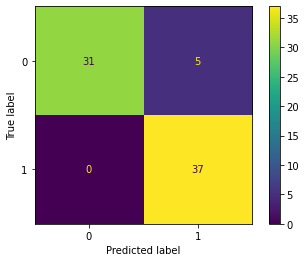

In [569]:
conf_matrix = confusion_matrix(y_true=expected, y_pred=predictions, labels=model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)

disp.plot()

plt.show()